#  Pruebas de rendimiento en el Hardware
Una vez que se ha conocido los pormenores de la API de  OpenVINO, es necesario hacer una comparación del rendimiento de la inferencia, a través de los tiempos de procesamiento, para ello se medirá los tiempos de carga de red y ejecución, para hacer una comparación

## Inicializar las variables de Entorno
Como siempre, hay que inicializar las variables de entorno de OpenVINO, por favor **ejecutar** la celda correspondiente: 
- *Windows*

In [ ]:
%%cmd
"C:\Program Files (x86)\Intel\openvino_2021\bin\setupvars.bat"

- *Linux*

In [4]:
%%bash
source /opt/intel/openvino_2021/bin/setupvars.sh

[setupvars.sh] OpenVINO environment initialized


## Descargar el archivo de ejemplo(si es que no ha sido descargado aún)

In [5]:
import os, sys
nombre_modelo = "person-detection-retail-0013"
ruta_archivo = os.getcwd()
ruta_modelo_xml = "intel/person-detection-retail-0013/FP32/person-detection-retail-0013.xml"
ruta_modelo_bin = ruta_modelo_xml.split(".")[0] + ".bin" #Cambiar la extensión de modelo a bin 

if (not os.path.isfile(ruta_modelo_xml)) and (not os.path.isfile(ruta_modelo_bin)):
    if sys.platform == "win32":
        ruta_model_downloader="C:\Program Files (x86)\Intel\openvino_2021\deployment_tools\tools\model_downloader\downloader.py"
        !python {ruta_model_downloader} --name {nombre_modelo}
        print("Ruta donde se guardó el archivo: {}".format(ruta_archivo))
    elif sys.platform == "linux":
        ruta_model_downloader="/opt/intel/openvino_2021/deployment_tools/tools/model_downloader/downloader.py"
        !python3 {ruta_model_downloader} --name {nombre_modelo}
        print("Ruta donde se guardó el archivo: {}".format(ruta_archivo))
else:
    print("Archivos actualmente descargados en {}{}".format(ruta_archivo, ruta_modelo_xml))

Archivos actualmente descargados en /home/josejacomeb/Documents/Workshop-ESPEL-MCT-2021/Sección 4intel/person-detection-retail-0013/FP32/person-detection-retail-0013.xml


## Uniendo todo
El anterior ejemplo de esta sección, se une en dos funciones para poder llamarlas en las siguientes celdas de código. 
**Nota:** En caso de no poder ejecutar el código anterior, desde el CMD de Windows o Terminal de Linux, primero inicializar las variables de entorno en el terminal y luego ejecutar el Jupyter Notebook.


### Cargar una imagen de ejemplo

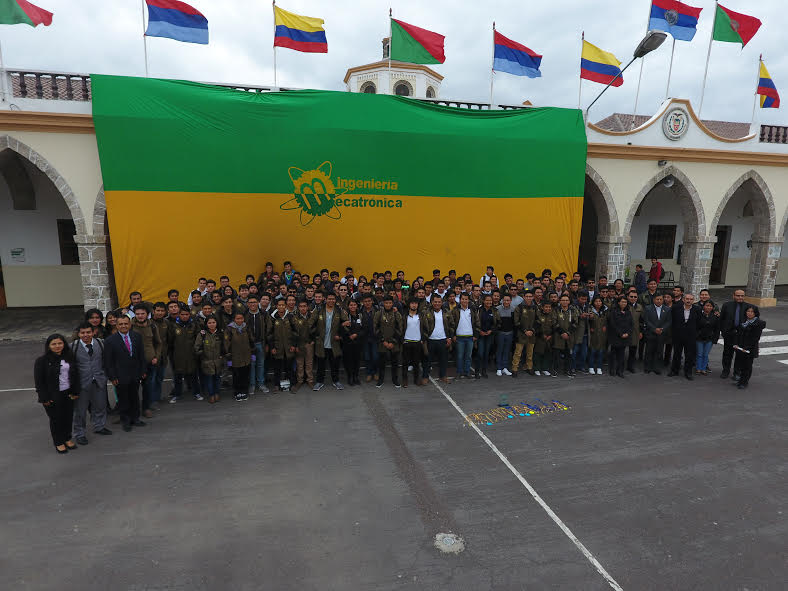

Forma del vector de entrada: (591, 788, 3)


In [11]:
import cv2
from PIL import Image
from IPython.display import display

imagen = cv2.imread("Imágenes/mct_personas.jpg")
imagen_mostrar = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB) # Convetir de BGR a RGB
display(Image.fromarray(imagen_mostrar)) 
print("Forma del vector de entrada: {}".format(imagen.shape))

### Realizar una función para cargar el modelo

In [27]:
#Cargar las clases de IECore, IENetwork
from openvino.inference_engine import IECore
import time #Medir el tiempo de carga

def cargar_modelo(ruta_modelo_xml, nombre_dispositivo_inferencia):
    inicio_tiempo = time.time()
    ruta_modelo_bin = ruta_modelo_xml.split(".")[0] + ".bin" #Cambiar la extensión de modelo a bin 

    core = IECore() #Inicializo el objeto IECore
    """
    Inicializo el objeto de tipo IENetwork a 
    través de la función core.read_network
    """
    network = core.read_network(model=ruta_modelo_xml, weights=ruta_modelo_bin) 

    resultado_capas = core.query_network(network, nombre_dispositivo_inferencia)
    capas_no_soportadas = ""
    for capa, dispositivo in resultado_capas.items():
        if dispositivo != nombre_dispositivo_inferencia:
            capas_no_soportadas += capa
            capas_no_soportadas += '\n'
    if capas_no_soportadas:
        print("Capas no soportadas para el dispositivo: {}\n {}".format(dispositivo, capas_no_soportadas))
        print("Se recomienda verificar en los demás dispositivos y hacer una ejecución heterogénea")
    else:
        print("Todas las capas están soportadas por el dispositivo: {}".format(nombre_dispositivo_inferencia))
    exec_network = core.load_network(network, nombre_dispositivo_inferencia) #Objeto de tipo ExecutableNetwork
    tiempo_final = time.time() - inicio_tiempo
    return exec_network, core, network, tiempo_final;

### Definición de la función para ajustar a la entrada del vector

In [28]:
import numpy as np
def preparar_array_entrada(imagen, forma_vector_entrada):
    #Formato OPENCV: H, W, C
    #Formato Capa Entrada: B, C, H, W
    imagen_correcta_alto_ancho = (forma_vector_entrada[3], forma_vector_entrada[2]) 
    imagen_correcta_entrada = cv2.resize(imagen, imagen_correcta_alto_ancho) #Resize argumento (W, H)
    imagen_correcta_entrada = np.transpose(imagen_correcta_entrada, (2, 0, 1))
    imagen_correcta_entrada = np.reshape(imagen_correcta_entrada, tuple(forma_vector_entrada))
    return imagen_correcta_entrada

### Definición de la función para graficar los resultados

In [29]:
import numpy as np
def dibujar_rectangulos(imagen, resultado_inferencia, umbral = 0.5):
    """
        Argumentos: 
        imagen: Imagen a la que se le dibujara los rectangulos
        resultado_inferencia: Resultado de la inferencia
        umbral: Minima confidencia que debe tener el resultado para ser aceptado
    """
    #Debido que la forma del resultado es 1, 1, N, 7
    imagen_resultado = imagen.copy()
    amarillo = (11,223,253)
    verde = (33,166,96)
    alto_imagen, ancho_imagen = imagen.shape[0:2]
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontScale = 0.5
    thickness = 1
    for deteccion in resultado_inferencia[0][0]:
         #Debido a que el resultado es [image_id, label, conf, x_min, y_min, x_max, y_max]
         if float(deteccion[2]) >= umbral: #Detecciones que son seguras
            x1 = int(deteccion[3]*ancho_imagen)
            y1 = int(deteccion[4]*alto_imagen)
            x2 = int(deteccion[5]*ancho_imagen)
            y2 = int(deteccion[6]*alto_imagen)
            imagen_resultado = cv2.rectangle(imagen_resultado, (x1, y1), (x2, y2), amarillo, 1)
            imagen_resultado = cv2.putText(imagen_resultado, str("{:.2f}".format(deteccion[2])), (x1, y2), font, fontScale, verde, thickness, cv2.LINE_AA)
    return imagen_resultado     

###  Función Inferencia Síncrona

In [52]:
def inferencia_sincrona(exec_network, network, imagen_corregida):
    nombre_capa_entrada = next(iter(network.input_info))
    forma_capa_entrada = network.input_info[nombre_capa_entrada].input_data.shape
    nombre_capa_salida = next(iter(network.outputs))
    tiempo_inicio = time.time()
    forma_capa_salida = network.outputs[nombre_capa_salida].shape
    imagen_corregida = preparar_array_entrada(imagen, forma_capa_entrada)
    resultado = exec_network.infer({nombre_capa_entrada: imagen_corregida})[nombre_capa_salida]
    tiempo_final = time.time() - tiempo_inicio
    return resultado, tiempo_final;
    

### Función Inferencia Asíncrona

In [53]:
def inferencia_asincrona(exec_network, network, imagen_corregida):
    nombre_capa_entrada = next(iter(network.input_info))
    forma_capa_entrada = network.input_info[nombre_capa_entrada].input_data.shape
    nombre_capa_salida = next(iter(network.outputs))
    tiempo_inicio = time.time()
    forma_capa_salida = network.outputs[nombre_capa_salida].shape
    imagen_corregida = preparar_array_entrada(imagen, forma_capa_entrada)
    #Inicia la inferencia asincrona
    estado_inferencia_handler = exec_network.start_async(request_id = 0, inputs = {nombre_capa_entrada: imagen_corregida}) #Enviar como diccionario con el nombre de la capa de entrada
    #Espera hasta que este listo el resultado
    estado_inferencia = estado_inferencia_handler.wait()
    #Recibe el resultado
    resultado = estado_inferencia_handler.output_blobs[nombre_capa_salida].buffer
    tiempo_final = time.time() - tiempo_inicio
    return resultado, tiempo_final;

## Inferencia Síncrona vs Asíncrona
En este ejemplo, se medirá los tiempos de la inferencia síncrona y asíncrona(un solo requests y con la función wait) en un CPU.
### Resultados Inferencia Síncrona en CPU

In [76]:
ruta_modelo_xml = "intel/person-detection-retail-0013/FP32/person-detection-retail-0013.xml"
nombre_dispositivo_inferencia="CPU"
exec_network, core, network, tiempo_carga = cargar_modelo(ruta_modelo_xml, nombre_dispositivo_inferencia)
nombre_capa_entrada = next(iter(network.input_info))
forma_capa_entrada = network.input_info[nombre_capa_entrada].input_data.shape
numero_pruebas = 50
tiempo_total = 0
for i in range(numero_pruebas):
    imagen_vector_entrada = preparar_array_entrada(imagen, forma_capa_entrada)
    resultado, tiempo_procesamiento = inferencia_sincrona(exec_network, network, imagen_vector_entrada)
    tiempo_total += tiempo_procesamiento

print("Tiempo de carga en Dispositivo {}: {:.3f} s".format(nombre_dispositivo_inferencia, tiempo_carga))
print("Tiempo promedio inferencia síncrona en Dispositivo {}: {:.4f} s".format(nombre_dispositivo_inferencia, tiempo_total/numero_pruebas))
print("Tiempo total para realizar {} inferencias en el dispositivo {}: {:.3f} s".format(numero_pruebas, nombre_dispositivo_inferencia, tiempo_total))

Todas las capas están soportadas por el dispositivo: CPU
Tiempo de carga en Dispositivo CPU: 0.265 s
Tiempo promedio inferencia síncrona en Dispositivo CPU: 0.0140 s
Tiempo total para realizar 50 inferencias en el dispositivo CPU: 0.700 s


### Resultado Inferencia Asíncrona en CPU

In [64]:
ruta_modelo_xml = "intel/person-detection-retail-0013/FP32/person-detection-retail-0013.xml"
nombre_dispositivo_inferencia="CPU"
exec_network, core, network, tiempo_carga = cargar_modelo(ruta_modelo_xml, nombre_dispositivo_inferencia)
nombre_capa_entrada = next(iter(network.input_info))
forma_capa_entrada = network.input_info[nombre_capa_entrada].input_data.shape
numero_pruebas = 50
tiempo_total = 0
for i in range(numero_pruebas):
    imagen_vector_entrada = preparar_array_entrada(imagen, forma_capa_entrada)
    resultado, tiempo_procesamiento = inferencia_asincrona(exec_network, network, imagen_vector_entrada)
    tiempo_total += tiempo_procesamiento

print("Tiempo de carga en Dispositivo {}: {:.3f} s".format(nombre_dispositivo_inferencia, tiempo_carga))
print("Tiempo promedio inferencia asíncrona en Dispositivo {}: {:.4f} s".format(nombre_dispositivo_inferencia, tiempo_total/numero_pruebas))
print("Tiempo total para realizar {} inferencias en el dispositivo {}: {:.3f} s".format(numero_pruebas, nombre_dispositivo_inferencia, tiempo_total))

Todas las capas están soportadas por el dispositivo: CPU
Tiempo de carga en Dispositivo CPU: 0.256 s
Tiempo promedio inferencia asíncrona en Dispositivo CPU: 0.013 s
Tiempo total para realizar 50 inferencias en el dispositivo CPU: 0.669 s


## Inferencia Asíncrona en varios Dispositivos
En este ejemplo, se medirá los tiempos de la inferencia asíncrona en varios dispositivos
### Resultados Inferencia Asíncrona en GPU

In [75]:
ruta_modelo_xml = "intel/person-detection-retail-0013/FP32/person-detection-retail-0013.xml"
nombre_dispositivo_inferencia="GPU"
exec_network, core, network, tiempo_carga = cargar_modelo(ruta_modelo_xml, nombre_dispositivo_inferencia)
nombre_capa_entrada = next(iter(network.input_info))
forma_capa_entrada = network.input_info[nombre_capa_entrada].input_data.shape
numero_pruebas = 50
tiempo_total = 0
for i in range(numero_pruebas):
    imagen_vector_entrada = preparar_array_entrada(imagen, forma_capa_entrada)
    resultado, tiempo_procesamiento = inferencia_asincrona(exec_network, network, imagen_vector_entrada)
    tiempo_total += tiempo_procesamiento

print("Tiempo de carga en Dispositivo {}: {:.3f} s".format(nombre_dispositivo_inferencia, tiempo_carga))
print("Tiempo promedio inferencia asíncrona en Dispositivo {}: {:.4f} s".format(nombre_dispositivo_inferencia, tiempo_total/numero_pruebas))
print("Tiempo total para realizar {} inferencias en el dispositivo {}: {:.3f} s".format(numero_pruebas, nombre_dispositivo_inferencia, tiempo_total))

Todas las capas están soportadas por el dispositivo: GPU
Tiempo de carga en Dispositivo GPU: 34.075 s
Tiempo promedio inferencia asíncrona en Dispositivo GPU: 0.0227 s
Tiempo total para realizar 50 inferencias en el dispositivo GPU: 1.137 s


### Resultados Inferencia Asíncrona en Myriad(Intel Neural Stick 2)

In [71]:
ruta_modelo_xml = "intel/person-detection-retail-0013/FP32/person-detection-retail-0013.xml"
nombre_dispositivo_inferencia="MYRIAD"
exec_network, core, network, tiempo_carga = cargar_modelo(ruta_modelo_xml, nombre_dispositivo_inferencia)
nombre_capa_entrada = next(iter(network.input_info))
forma_capa_entrada = network.input_info[nombre_capa_entrada].input_data.shape
numero_pruebas = 50
tiempo_total = 0
for i in range(numero_pruebas):
    imagen_vector_entrada = preparar_array_entrada(imagen, forma_capa_entrada)
    resultado, tiempo_procesamiento = inferencia_asincrona(exec_network, network, imagen_vector_entrada)
    tiempo_total += tiempo_procesamiento

print("Tiempo de carga en Dispositivo {}: {:.3f} s".format(nombre_dispositivo_inferencia, tiempo_carga))
print("Tiempo promedio inferencia asíncrona en Dispositivo {}: {:.4f} s".format(nombre_dispositivo_inferencia, tiempo_total/numero_pruebas))
print("Tiempo total para realizar {} inferencias en el dispositivo {}: {:.3f} s".format(numero_pruebas, nombre_dispositivo_inferencia, tiempo_total))

Todas las capas están soportadas por el dispositivo: MYRIAD
Tiempo de carga en Dispositivo MYRIAD: 2.253 s
Tiempo promedio inferencia asíncrona en Dispositivo MYRIAD: 0.1326 s
Tiempo total para realizar 50 inferencias en el dispositivo MYRIAD: 6.631 s


### Resultados de Inferencia Asíncrona usando el Plugin AUTO
El plugin Auto[1] de OpenVINO, delega al software a hacer la selección del mejor acelerador de inferencia(GPU, MYRIAD, etc) a través de la decisión de los dispositivos disponibles y la característica de la CNN como la precisión.

In [74]:
ruta_modelo_xml = "intel/person-detection-retail-0013/FP32/person-detection-retail-0013.xml"
nombre_dispositivo_inferencia="AUTO"
exec_network, core, network, tiempo_carga = cargar_modelo(ruta_modelo_xml, nombre_dispositivo_inferencia)
nombre_capa_entrada = next(iter(network.input_info))
forma_capa_entrada = network.input_info[nombre_capa_entrada].input_data.shape
numero_pruebas = 50
tiempo_total = 0
for i in range(numero_pruebas):
    imagen_vector_entrada = preparar_array_entrada(imagen, forma_capa_entrada)
    resultado, tiempo_procesamiento = inferencia_asincrona(exec_network, network, imagen_vector_entrada)
    tiempo_total += tiempo_procesamiento

print("Tiempo de carga en Dispositivo {}: {:.3f} s".format(nombre_dispositivo_inferencia, tiempo_carga))
print("Tiempo promedio inferencia asíncrona en Dispositivo {}: {:.4f} s".format(nombre_dispositivo_inferencia, tiempo_total/numero_pruebas))
print("Tiempo total para realizar {} inferencias en el dispositivo {}: {:.3f} s".format(numero_pruebas, nombre_dispositivo_inferencia, tiempo_total))

Todas las capas están soportadas por el dispositivo: AUTO
Tiempo de carga en Dispositivo AUTO: 31.275 s
Tiempo promedio inferencia asíncrona en Dispositivo AUTO: 0.0242 s
Tiempo total para realizar 50 inferencias en el dispositivo AUTO: 1.208 s


## Resultados del Experimento
El experimento realizado aquí, hizo con el siguiente hardware, los resultados variarán de PC a PC:
- `CPU`: Intel(R) Core(TM) i7-6700HQ CPU @ 2.60GHz
- `GPU`: Intel Corporation HD Graphics 530 (Intel HD 3000)
- `Myriad`: Intel Neural Compute Stick 2
- `AUTO`: Presumiblemente Intel Seleccionó la GPU integrada

### Pruebas de Inferencia Sincrónica y Asincrónica en CPU
En la siguiente prueba, la inferencia asincrónica es ligeramente más rápida que la sincrónica, incluso con más margen de mejora aplicando técnicas de procesamiento paralelo.
![Inferencia Sync/Async](Imágenes/inferencia_sync_async.png)
<div align="center"><b>Fig 1.</b> Tiempos de inferencia asincrónica y sincrónica con CPU en segundos(menos es mejor)</div>

### Pruebas de carga del modelo en diferentes dispositivos
Los tiempos de carga del modelo en distintos dispositivos dependiendo del proceso, puede ser crucial o no, el CPU y el MYRIAD fueron los dispositivos más rápidos, mientras que cargar el Modelo en la GPU puede llevar más tiempo, que se debe considerar.

![Inferencia Sync/Async](Imágenes/carga_async.png)
<div align="center"><b>Fig 3.</b> Tiempos de carga de los modelos en distintos dispositivos(menos es mejor)</div>

### Pruebas de Inferencia en varios dispositivos
Los tiempos de inferencia, para el CPU de prueba, fueron los mejores, un poco por encima se ubicó el valor del GPU integrado(que puede aliviar la carga del CPU para otras tareas) y tercero el MYRIAD; que es 10 veces más lento que un CPU, pero interesante para dispositivos de frontera.

![Inferencia Sync/Async](Imágenes/inferencia_async.png)
<div align="center"><b>Fig 2.</b> Tiempos de inferencia promedio asincrónica en dispositivos en segundos(menos es mejor)</div>




## Referencias
- [1] Intel. (2021, Agosto 31).Supported Framework Layers. Intel. [https://docs.openvinotoolkit.org/latest/openvino_docs_IE_DG_supported_plugins_AUTO.html](https://docs.openvinotoolkit.org/latest/openvino_docs_IE_DG_supported_plugins_AUTO.html)
